In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from tqdm import tqdm

from synthdid.model import SynthDID
from synthdid.sample_data import fetch_CaliforniaSmoking

In [2]:
df = fetch_CaliforniaSmoking()

PRE_TEREM = [1970, 1988]
POST_TEREM = [1989, 2000]

TREATMENT = ["California"]

sdid = SynthDID(df, PRE_TEREM, POST_TEREM, TREATMENT)
sdid.fit(zeta_type="base")

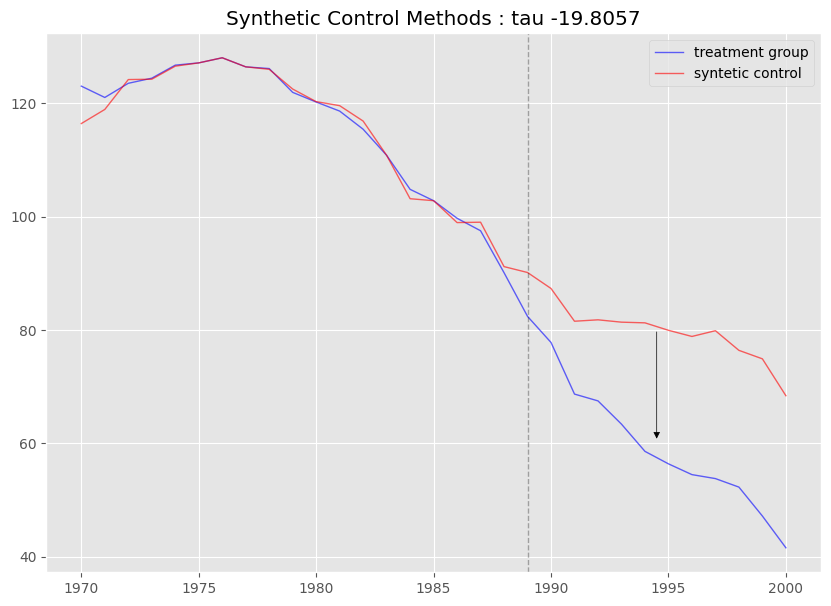

In [3]:
sdid.plot(model="sc")

In [7]:
hat_omega_sc = sdid.estimated_params(model="sc")

cm = sns.light_palette("green", as_cmap=True)
hat_omega_sc.query("sc_weight >0").sort_values(
    by="sc_weight", ascending=False
).style.background_gradient(cmap=cm)

,features,sc_weight
32,Utah,0.340000
17,Montana,0.333000
19,Nevada,0.222000
3,Connecticut,0.066000
2,Colorado,0.023000
20,New Hampshire,0.016000


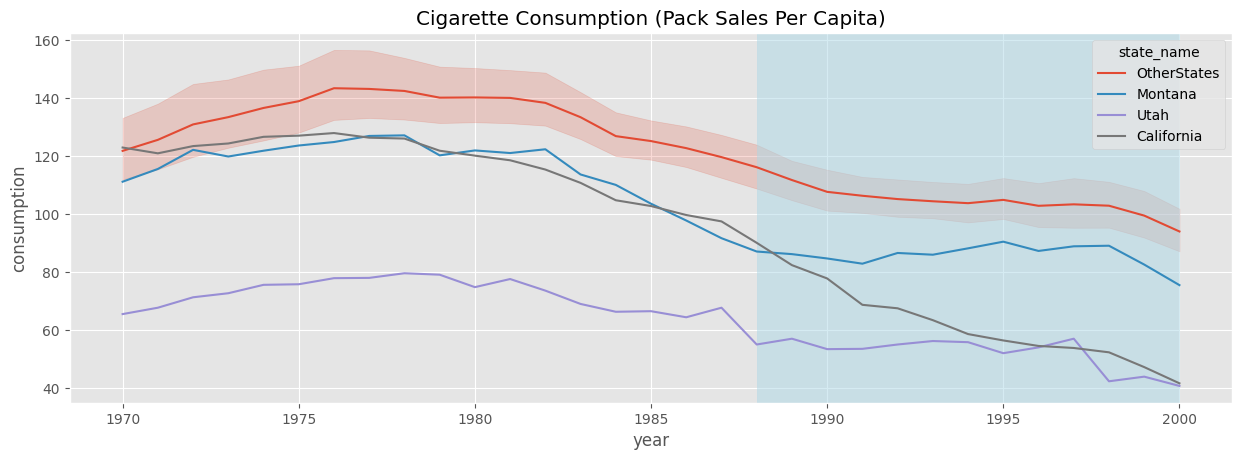

In [8]:
melt_df = pd.melt(
    df.reset_index().rename(columns={"index": "year"}),
    id_vars="year",
    value_name="consumption",
    var_name="state",
)
melt_df["state_name"] = np.where( melt_df["state"] == "California", "California", "OtherStates")
melt_df.loc[melt_df["state"] == "Utah", "state_name"] =  "Utah"
melt_df.loc[melt_df["state"] == "Montana", "state_name"] =  "Montana"

fig, ax = plt.subplots()
fig.set_figwidth(15)

sns.lineplot(x="year", y="consumption", hue="state_name", data=melt_df, ax=ax)

ax.axvspan(1988, 2000, alpha=0.5, color="lightblue")

plt.title("Cigarette Consumption (Pack Sales Per Capita)")
plt.show()

## test 1 : Utah

In [9]:
expand_list = [0.01, 0.1, 0.5, 0.8, 1, 1.2, 1.5, 2, 10, 50, 100]

In [10]:
utah_omega = {}
utah_tau = {}

for _e in tqdm(expand_list):
    if _e != 1:
        _df = df.copy()
        _df["Utah"] = _df["Utah"] * _e
        # re-run
        _sdid = SynthDID(_df, PRE_TEREM, POST_TEREM, TREATMENT)
        _sdid.fit(zeta_type="base")

        utah_tau[_e] = _sdid.hat_tau()
        hat_omega_sdid, _ = _sdid.estimated_params()

    else:
        utah_tau[_e] = sdid.hat_tau()
        hat_omega_sdid, _ = sdid.estimated_params()

    utah_omega[_e] = hat_omega_sdid.query("features == 'Utah'")[
        "sdid_weight"
    ].values[0]

100%|██████████| 11/11 [00:37<00:00,  3.39s/it]


In [11]:
utah_tau = pd.DataFrame(utah_tau, index = ["tau"]).T
utah_omega = pd.DataFrame(utah_omega, index = ["weight"]).T

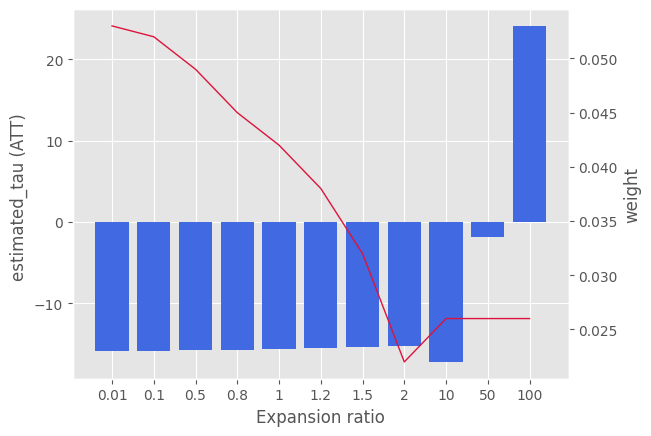

In [12]:
_expand_list = [ str(_e) for _e in expand_list ]

fig, ax1 = plt.subplots()
ax1.bar(_expand_list , utah_tau["tau"], align="center", color="royalblue", linewidth=0, label="tau")
ax1.set_ylabel('estimated_tau (ATT) ')
ax1.set_xlabel('Expansion ratio')
 
ax2 = ax1.twinx()
ax2.plot(_expand_list , utah_omega["weight"], linewidth=1, color="crimson", label="weight")
ax2.set_ylabel('weight')
ax2.grid(False)

plt.show()

In [13]:
utah_tau.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
tau,-15.880635,-15.880307,-15.799122,-15.688345,-15.607966,-15.517343,-15.405763,-15.242742,-17.210081,-1.887662,24.093409


In [14]:
utah_omega.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
weight,0.053,0.052,0.049,0.045,0.042,0.038,0.032,0.022,0.026,0.026,0.026
